## Fraud Detection in Credit Card Transactions using ML Techniques
*Oladimeji Salau*  
https://github.com/dimtics

### Introduction
The objective in this project is to build machine learning models to classify or identify fraudulent card transactions from a given card transactions data.  

### Data Description

The [dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) contains two-days credit card transactions made in September 2013 by European cardholders. The dataset is highly unbalanced with a low percentage of fraudulent transactions within several records of normal transactions. The positive class (frauds) account for 0.172% (492 frauds out of 284,807 transactions) of all transactions.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.  Feature 'Class' is the target variable with value 1 in case of fraud and 0 otherwise. 

### Import Libraries

In [1]:
# Import basic libraries 
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import ADASYN 
from collections import Counter
import seaborn as sn

# plot functions
import plot_functions as pf

# scikit packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn import metrics

# settings
%matplotlib inline
sn.set_style("dark")
sn.set_palette("colorblind")

### Load Data  
The dataset used in this project is freely available at: https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [2]:
df = pd.read_csv("data/creditcard.csv")

In [3]:
# View top 5 records
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# determine the number of records in the dataset
print('The dataset contains {0} rows and {1} columns.'.format(df.shape[0], df.shape[1]))

The dataset contains 284807 rows and 31 columns.


In [5]:
# check for missing values and data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

### Explore label class

In [6]:
print('Normal transactions count: ', df['Class'].value_counts().values[0])
print('Fraudulent transactions count: ', df['Class'].value_counts().values[1])

Normal transactions count:  284315
Fraudulent transactions count:  492


### Separate feature data (predictors) from labels

In [7]:
# feature data (predictors)
X = df.iloc[:, :-1]

# label class
y = df['Class']

### Standardize data
Scale the data to have zero mean and unit variance.

In [8]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

### Partition data into train and test sets

In [9]:
# Partition data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.33, random_state=42)

### Data Sampling  
As noted earlier, the dataset is unbalanced. Training unbalanced dataset with learning algorithms may lead to misclassification of minority class. Therefore, to compensate for the unbalancedness, we will use ADASYN oversampling method as implemented in imbalanced-learn package to resample the dataset.  
ADASYN (ADAptive SYNthetic) is an [oversampling technique](https://www.datasciencecentral.com/profiles/blogs/handling-imbalanced-data-sets-in-supervised-learning-using-family) that adaptively generates minority data samples according to their distributions using K nearest neighbor. 

In [10]:
# apply the ADASYN over-sampling
ada = ADASYN(random_state=42)
print('Original dataset shape {}'.format(Counter(y_train)))
X_res, y_res = ada.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 190477, 1: 343})
Resampled dataset shape Counter({0: 190477, 1: 190471})


### Train Models  
Three machine learning algorithms: Logistic Regression, Naive Baye, and RandomForest classifiers were trained using the processed feature data.

In [11]:
X_train, y_train = X_res, y_res 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression()
LGR_Classifier.fit(X_train, y_train);

# Train Decision Tree Model
RDF_Classifier = RandomForestClassifier(random_state=0)
RDF_Classifier.fit(X_train, y_train);

# Train Bernoulli Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, y_train);

### Evaluate Models  

In [12]:
# Evaluate models
modlist = [('RandomForest Classifier', RDF_Classifier),('LogisticRegression', LGR_Classifier),
('Naive Baiye Classifier', BNB_Classifier)] 

models = [j for j in modlist]

print()
print('========================== Model Evaluation Results ========================' "\n")  

for i, v in models:
    scores = cross_val_score(v, X_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(y_train, v.predict(X_train))
    classification = metrics.classification_report(y_train, v.predict(X_train))
    print('===== {} ====='.format(i))
    print()
    print ("Cross Validation Mean Score: ", '{}%'.format(np.round(scores.mean(), 3) * 100))  
    print() 
    print ("Model Accuracy: ", '{}%'.format(np.round(accuracy, 3) * 100)) 
    print()
    print("Confusion Matrix:" "\n", confusion_matrix)
    print()
    print("Classification Report:" "\n", classification) 
    print()


========================== Model Evaluation Results ========================

===== RandomForest Classifier =====

Cross Validation Mean Score:  92.5%

Model Accuracy:  100.0%

Confusion Matrix:
 [[190477      0]
 [     0 190471]]

Classification Report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    190477
          1       1.00      1.00      1.00    190471

avg / total       1.00      1.00      1.00    380948


===== LogisticRegression =====

Cross Validation Mean Score:  87.4%

Model Accuracy:  90.10000000000001%

Confusion Matrix:
 [[174053  16424]
 [ 21296 169175]]

Classification Report:
              precision    recall  f1-score   support

          0       0.89      0.91      0.90    190477
          1       0.91      0.89      0.90    190471

avg / total       0.90      0.90      0.90    380948


===== Naive Baiye Classifier =====

Cross Validation Mean Score:  83.6%

Model Accuracy:  84.7%

Confusion Matrix:
 [[170272  

### Test Models


========================== Model Test Results ========================

=== RandomForest Classifier ===
Model Accuracy:  100.0%

Confusion Matrix:
 [[93816    22]
 [   24   125]]



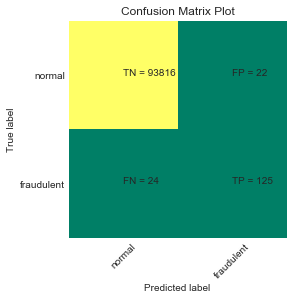


Classification Report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     93838
          1       0.85      0.84      0.84       149

avg / total       1.00      1.00      1.00     93987


=== LogisticRegression ===
Model Accuracy:  91.2%

Confusion Matrix:
 [[85582  8256]
 [    7   142]]



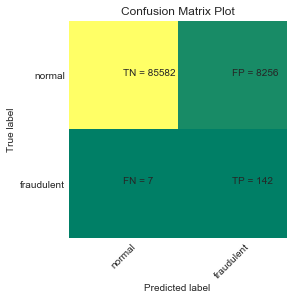


Classification Report:
              precision    recall  f1-score   support

          0       1.00      0.91      0.95     93838
          1       0.02      0.95      0.03       149

avg / total       1.00      0.91      0.95     93987


=== Naive Baiye Classifier ===
Model Accuracy:  89.4%

Confusion Matrix:
 [[83840  9998]
 [   10   139]]



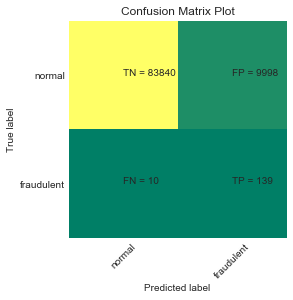


Classification Report:
              precision    recall  f1-score   support

          0       1.00      0.89      0.94     93838
          1       0.01      0.93      0.03       149

avg / total       1.00      0.89      0.94     93987


============================= ROC Curve ===============================



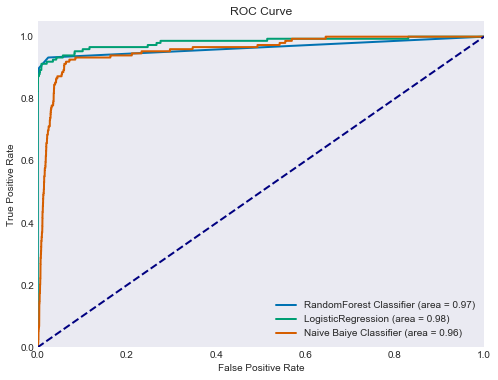

In [13]:
# Test models
classdict = {'normal':0, 'fraudulent':1}
print()
print('========================== Model Test Results ========================' "\n")   

for i, v in models:
    accuracy = metrics.accuracy_score(y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(y_test, v.predict(X_test))
    classification = metrics.classification_report(y_test, v.predict(X_test))   
    print('=== {} ==='.format(i))
    print ("Model Accuracy: ",  '{}%'.format(np.round(accuracy, 3) * 100))
    print()
    print("Confusion Matrix:" "\n", confusion_matrix)
    print()
    pf.plot_confusion_matrix(confusion_matrix, classes = list(classdict.keys()), title='Confusion Matrix Plot', cmap=plt.cm.summer)
    print() 
    print("Classification Report:" "\n", classification) 
    print() 

print('============================= ROC Curve ===============================' "\n")      
pf.plot_roc_auc(arg1=models, arg2=X_test, arg3=y_test)